In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import minimize, differential_evolution, line_search, BFGS, SR1, NonlinearConstraint
from numdifftools import Gradient

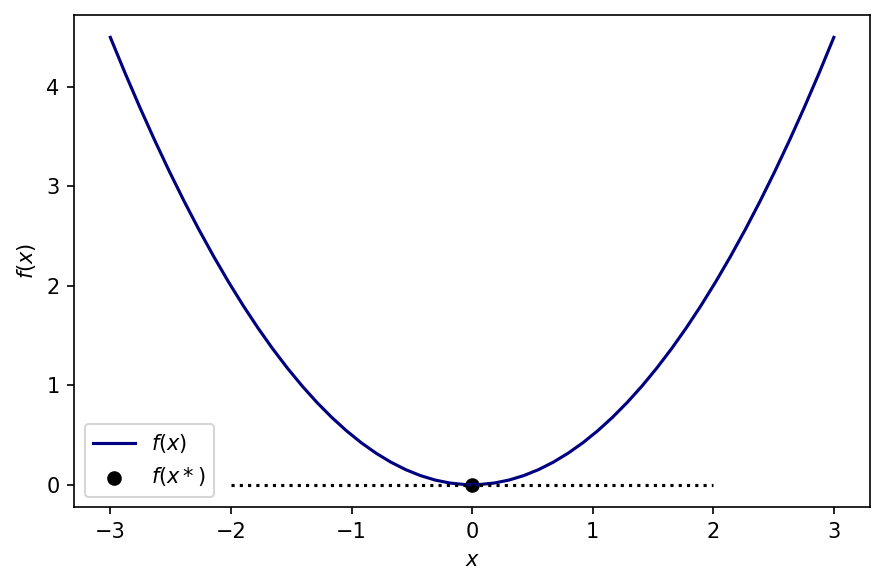

In [4]:
x = np.linspace(-3, 3)
f = lambda x: x ** 2 / 2
slope = lambda x: 2 * x

#Define tangent line
def tan_line(x, x0):
    return slope(x0) * (x - x0) + f(x0)

phi = f(x)

fig, ax = plt.subplots(figsize=[6, 4], dpi=150)

ax.plot(x, phi, color="navy", label=r"$f(x)$")

x0 = np.array([0])
line_x0 = np.array([-2, 2]) + x0
ax.scatter(x0, f(x0), label=r"$f(x*)$", color="black")
ax.plot(line_x0, tan_line(line_x0, x0), color="black", linestyle=":")

ax.legend()

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")

plt.tight_layout()

plt.show()

In [5]:
#Defining the objective function
def obj_fun(x):

    return (x[0] - 0.5) ** 2 + 0.7 * x[0] * x[1] + 1.2 * (x[1] + 0.7) ** 2

#Defining the gradient function
def gradient_fun(x):

    return np.array([2 * (x[0] - 0.5) + 0.7 * x[1], 0.7 * x[0] + 2 * 1.2 * (x[1] + 0.7)])

#Defining the Hessian function
def hess_fun(x):

    return np.array([[2., 0.7],
                     [0.7, 2. * 1.2]])


In [6]:
true_optima = - np.linalg.solve(hess_fun([0, 0]), gradient_fun([0, 0]))
print(true_optima)

[ 0.82969838 -0.94199536]


In [7]:
#Creating a countouf plot
n_mesh = 500

x1 = np.linspace(-5, 5, n_mesh)
x2 = np.linspace(-5, 5, n_mesh)

X1, X2 = np.meshgrid(x1, x2)

X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_fun(x) for x in X.T])

y = F.copy().reshape([n_mesh, n_mesh])

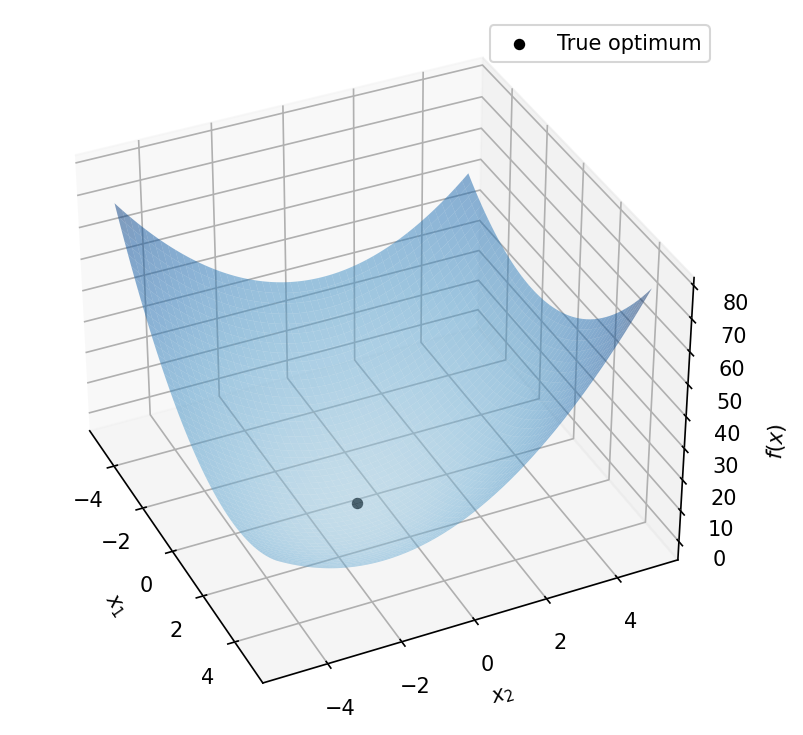

In [9]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={"projection": "3d"})

ax.view_init(35, -25)

surf = ax.plot_surface(X1, X2, y, antialiased=True, cmap="Blues", alpha=0.5, vmin=-50, zorder=-1)

ax.scatter([true_optima[0]],  [true_optima[1]], zs=0, marker="o", color="black", label="True optimum", zorder=1)
ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")

plt.tight_layout()

plt.show()

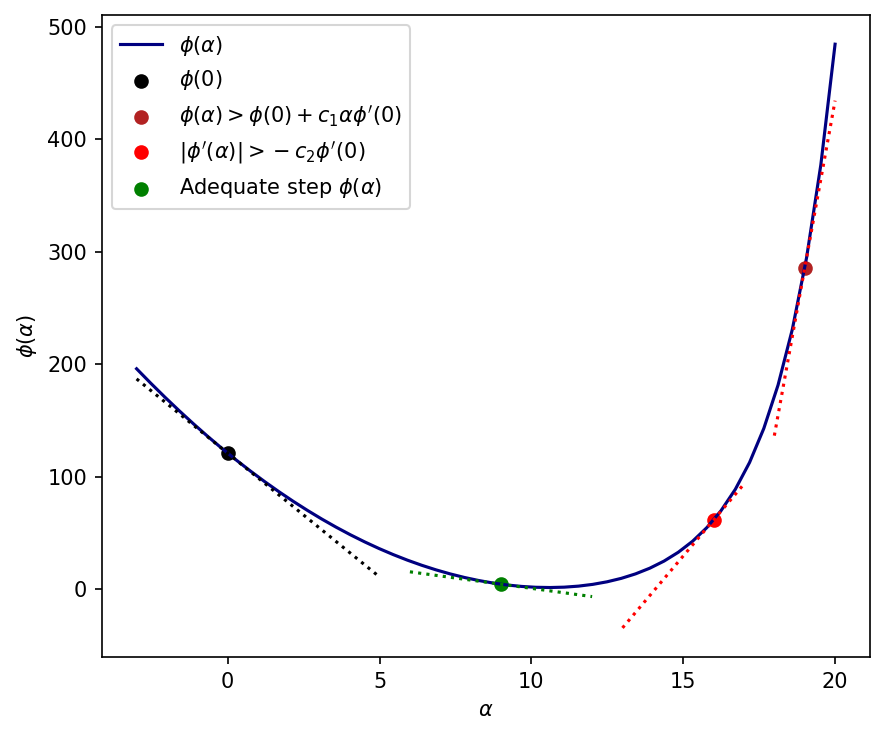

In [10]:
x = np.linspace(-3, 20)
f = lambda x: np.exp((x - 10) * 0.6) + (x - 11) ** 2
slope = lambda x: 0.6 * np.exp((x - 10) * 0.6) + 2 * (x - 11)

#Define tangent line
def tan_line(x, x0):
    return slope(x0) * (x - x0) + f(x0)

phi = f(x)

fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

ax.plot(x, phi, color="navy", label=r"$\phi(\alpha)$")

x0 = np.array([0])
line_x0 = np.array([-3, 5]) + x0
ax.scatter(x0, f(x0), label=r"$\phi(0)$", color="black")
ax.plot(line_x0, tan_line(line_x0, x0), color="black", linestyle=":")

x1 = np.array([19])
line_x1 = np.array([-1, 1]) + x1
ax.scatter(x1, f(x1), label=r"$\phi(\alpha) > \phi(0) + c_1 \alpha \phi'(0)$", color="firebrick")
ax.plot(line_x1, tan_line(line_x1, x1), color="red", linestyle=":")

x2 = np.array([16])
line_x2 = np.array([-3, 1]) + x2
ax.scatter(x2, f(x2), label=r"|$\phi'(\alpha)| > -c_2 \phi'(0)$", color="red")
ax.plot(line_x2, tan_line(line_x2, x2), color="red", linestyle=":")

x3 = np.array([9])
line_x3 = np.array([-3, 3]) + x3
ax.scatter(x3, f(x3), label=r"Adequate step $\phi(\alpha)$", color="green")
ax.plot(line_x3, tan_line(line_x3, x3), color="green", linestyle=":")

ax.legend()

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\phi(\alpha)$")

plt.tight_layout()

plt.show()

In [11]:
class DescentAlgorithm:

    def __init__(self, fun, gradient=None, hess=None, nd={}, wolfe_c1=1e-4, wolfe_c2=0.1,
                 x_tol=1e-6, f_tol=1e-6, max_iter=50, save_history=False):

        self.fun = fun

        if gradient is None:
            self.gradient = Gradient(fun, **nd)
        else:
            self.gradient = gradient

        self.hess = hess
        self.wolfe_coefs = wolfe_c1, wolfe_c2
        self.x_tol = x_tol
        self.f_tol = f_tol
        self.max_iter = max_iter
        self.save_history = save_history
        self.history = []

    def optimize(self, x0, *args, **kwargs):

        x0 = np.atleast_1d(x0).astype(float)
        self.history = []

        xk = x0.copy()
        fk = self.fun(x0, *args, **kwargs)
        gradk = self.gradient(x0, *args, **kwargs)

        fc, gc = 1, 1

        pk = self.prepare_initial_step(xk, fk, gradk, *args, **kwargs)

        advance_x, advance_f, advance_max = True, True, True
        k = 0

        if self.save_history:
            self.history.append({"x":xk, "f":fk, "grad":gradk})

        while (advance_x or advance_f) and (k <= self.max_iter):

            alpha, fc_, gc_, fnew, fk, gradnew = line_search(self.fun, self.gradient,
                                                             xk, pk, gradk, fk, args=args,
                                                             c1=self.wolfe_coefs[0],
                                                             c2=self.wolfe_coefs[1],
                                                             maxiter=15)

            if alpha is None:
                alpha = 1
                fnew = self.fun(xk + alpha * pk, *args, **kwargs)
                gradnew = self.gradient(xk + alpha * pk, *args, **kwargs)

            xnew = xk + alpha * pk
            fc = fc + fc_
            gc = gc + gc_

            if gradnew is None:
                gradnew = self.gradient(xnew)

            advance_f = abs(fnew - fk) > self.f_tol
            advance_x = np.linalg.norm(xnew - xk) > self.x_tol

            xk, fk, gradk, pk = self.prepare_next_step(xk, fk, gradk, pk, xnew, fnew, gradnew, *args, **kwargs)

            k = k + 1

            if self.save_history:
                self.history.append({"x":xk, "f":fk, "grad":gradk})

            if np.linalg.norm(pk) < np.sqrt(np.finfo(float).eps):
                self.message = 'Negligible step'
                self.success = True
                break

        if not (advance_x or advance_f):
            self.success = True
            self.message = 'Tolerance reached'

        elif k > self.max_iter:
            self.success = False
            self.message = 'Max iterations reached'

        self.x = xk
        self.f = fk
        self.grad = gradk
        self.fc = fc
        self.gc = gc
        self.result = {"x":xk, "f":fk, "grad":gradk, "iter":k, "message":self.message, "success":self.success}

    def prepare_next_step(self, xk, fk, gradk, pk, xnew, fnew, gradnew, *args, **kwargs):
        pass

    def prepare_initial_step(self, xk, fk, gradk, *args, **kwargs):
        pass